**Algoritmo de prevención de fraude:**
---

¡¡Hola!! En este proyecto veremos como generar un algoritmo para detectar posibles riesgos de fraude en transacciones bancarias de clientes. Para ello avanzaremos paso por paso desde el inicio. Veremos como extraer la información, como transformarla, como aplicar correlación para poder ver como se relacionan entre si las distintas variables y con todo esto poder realizar gráficos que ayuden a visualizar dichas relaciones. Luego analízaremos cual es el mejor método estadístico para realizar machine learning y lo entrenaremos con los datos ya procesados.

El dataset utlizado en este caso es obtenido del siguiente link:
https://www.kaggle.com/datasets/ealaxi/paysim1

Además de generar un algoritmo preciso que permita predecir fraude analizaremos los datos para contestar las siguientes preguntas:

1) ¿Qué porcentaje de casos fraudulentos se encuentran entre los datos?
2) ¿Cuales son los tipos de transacciones mas probables de que sean fraude?
3) ¿Cuáles son las propiedades que mayor correlatividad tienen con nuestra variable objetivo?

**IMPORTACIÓN Y ESTUDIO DE LOS DATOS**
--

In [1]:
# Cargamos las librerías necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import tree
from sklearn import metrics
from sklearn import svm

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score as crossval
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

np.random.seed(0)

In [2]:
# importamos el dataset

df = pd.read_csv(r"C:\Users\Francisco\Documents\DataScience\Proyecto_final_data_science\Dataset\PS_20174392719_1491204439457_log.csv")


In [3]:
# chequeamos la información que contiene

print('INFORMACIÓN DEL DATASET:')
print('------------------------')
print(df.info())
print('')
print('**************************')
print('TAMAÑO DEL DATASET:')
print(df.shape)

INFORMACIÓN DEL DATASET:
------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None

**************************
TAMAÑO DEL DATASET:
(6362620, 11)


In [4]:
# Chequeamos si hay valores nulos

df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
# Hechamos un vistazo a los valores

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
# Por último chequeamos la información estadística de los datos

df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


Se puede observar una diferencia muy grande en los valores por lo que es necesario emplear un proceso de normalización de los datos el cual lo haremos mas adelante. Pero primero corregiremos el nombre de oldbalanceOrg, cambiándolo a oldbalanceOrig así se utiliza la misma nomenclatura para todos los casos

In [7]:
df = df.rename(columns={'oldbalanceOrg' : 'oldbalanceOrig'})
df.head(2)

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0


Interesa, para el caso de estudio, descubrir cuándo es más frecuente que ocurran los fraudes. Por ello, se estudia la distribución de la variable type.

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


Text(0.5, 1.0, 'Distribución del tipo de transacción')

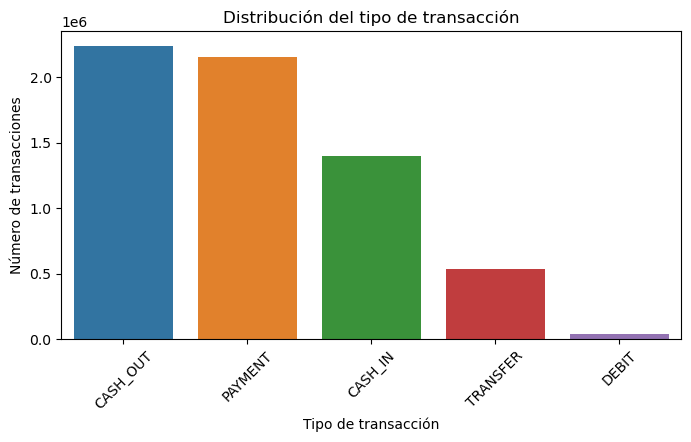

In [8]:
print(df['type'].value_counts())

plt.rcParams['figure.figsize']=[8,4]
sns.countplot(x='type', data=df, order=df['type'].value_counts().index)
plt.xticks(rotation= 45) # Rotación del texto en el eje x
plt.xlabel('Tipo de transacción')
plt.ylabel('Número de transacciones')
plt.title('Distribución del tipo de transacción')

Vemos que las transacciones más comunes son PAYMENTS y CASH_OUT

**Ahora analizaremos nuestra variable objetivo o dependiente, la cual será "isFraud"**

In [9]:
isFraud_df = df[df['isFraud'] == 1]

isFraud_df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0


**Respuesta a la pregunta 1:**
**¿Qué porcentaje de casos fraudulentos se encuentran entre los datos?**


In [10]:
print('el total de casos de estudio es de:', df['isFraud'].count())
totalFraud = df['isFraud'].sum()
print(f'El total de casos de fraudes es: {totalFraud}' )
percentFraud = (df['isFraud'].sum() / df['isFraud'].count())*100
print(f'El porcentaje de casos de fraude es: {percentFraud:.2f} %')

el total de casos de estudio es de: 6362620
El total de casos de fraudes es: 8213
El porcentaje de casos de fraude es: 0.13 %


La cantidad de transacciones fraudulentas son muy pocas en comparación a las no fraudulentas, mas adelante las normalizaremos para evitar una generalización de nuestro modelo de predicción.

Para tener una idea más clara de qué tipo de transacciones son más comunes a la hora de cometer fraude, realizamos el siguiente gráfico

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64


Text(0.5, 1.0, 'Tipo de transacción cuando hay fraude')

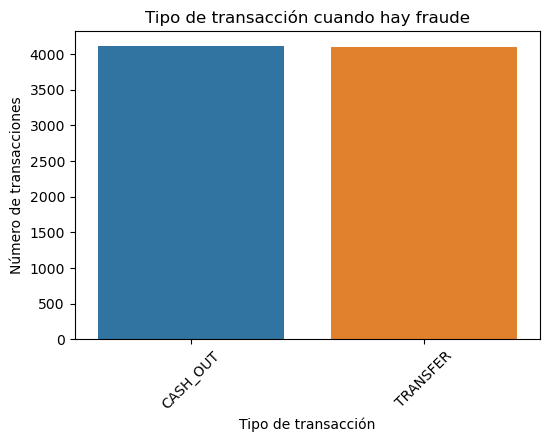

In [11]:
print(df[(df['isFraud'] == 1)]['type'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x='type', data=df[(df['isFraud'] == 1)], order=df[(df['isFraud'] == 1)]['type'].value_counts().index)
plt.xticks(rotation= 45) # Rotación del texto en el eje x
plt.xlabel('Tipo de transacción')
plt.ylabel('Número de transacciones')
plt.title('Tipo de transacción cuando hay fraude')

**Respuesta a la pregunta 2: ¿Cuales son los tipos de transacciones mas probables de que sean fraude?**

Este gráfico revela información muy valiosa. Las transacciones fraudulentas sólo ocurren cuando es de tipo TRANSFER (transferencia) y CASH_OUT (sacar dinero)

En el siguiente gráfico se puede ver la distribución de la variable "isFraud" con "amount".

<Axes: xlabel='isFraud', ylabel='amount'>

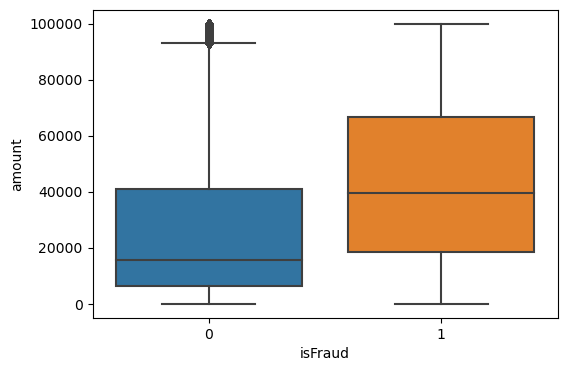

In [12]:
plt.figure(figsize=(6,4))
sns.boxplot(x = 'isFraud', y = 'amount', data = df[df.amount < 1e5])

Se aprecia que el fraude ocurre de manera más frecuente cuando la variable amount es mayor

**Analicemos ahora la variable "isFlaggedFraud"**

In [13]:
isFlaggedFraud_df = df[(df['isFlaggedFraud'] == 1)]

print('valores positivos: ' , isFlaggedFraud_df.shape)
print('-----------------------')
print(isFlaggedFraud_df.head())
print(isFlaggedFraud_df.tail())

valores positivos:  (16, 11)
-----------------------
         step      type       amount     nameOrig  oldbalanceOrig  \
2736446   212  TRANSFER   4953893.08   C728984460      4953893.08   
3247297   250  TRANSFER   1343002.08  C1100582606      1343002.08   
3760288   279  TRANSFER    536624.41  C1035541766       536624.41   
5563713   387  TRANSFER   4892193.09   C908544136      4892193.09   
5996407   425  TRANSFER  10000000.00   C689608084     19585040.37   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
2736446      4953893.08   C639921569             0.0             0.0        1   
3247297      1343002.08  C1147517658             0.0             0.0        1   
3760288       536624.41  C1100697970             0.0             0.0        1   
5563713      4892193.09   C891140444             0.0             0.0        1   
5996407     19585040.37  C1392803603             0.0             0.0        1   

         isFlaggedFraud  
2736446            

Estudiando esta variable se detecta un patrón interesante. De los 16 registros existentes en el dataset, TODOS tienen las variables oldbalanceDest y newbalanceDest a 0.

Además, la variable oldbalanceOrg y newbalanceOrg tienen también exactamente el mismo valor, no se descuenta la cantidad de dinero de la transacción

También se aprecia que sólo las de type TRANSFER tienen la variable isFlaggedFraud a 1, es decir, sólo cuando hay una transacción superior a 200k, el sistema marca, de forma preventiva, esa transacción como fraudulenta

In [14]:
# Total de transacciones fraudulentas

total = df[(df['isFraud'] == 1)]['type'].count()
print(f'Existen {total} observaciones que son fraude')
print('')

# Total de transacciones fraudulentas donde ambas variables dan 0

ambas = isFraud_df[(isFraud_df['newbalanceDest'] == 0) | (isFraud_df['oldbalanceDest'] == 0)].count()['oldbalanceDest']
print(f'Las veces que aparecen ambas variables, newbalanceDest = oldbalanceDest = 0, cuando la observación es fraude es de {ambas} veces')
print('')

# Calculo del porcentaje

porcentaje = (ambas / total) * 100 
print(f'El porcentaje de observaciones con 0 en las variables cuando hay fraude es del {porcentaje: .2f} % ')

Existen 8213 observaciones que son fraude

Las veces que aparecen ambas variables, newbalanceDest = oldbalanceDest = 0, cuando la observación es fraude es de 5366 veces

El porcentaje de observaciones con 0 en las variables cuando hay fraude es del  65.34 % 


**Observemos ahora el dataframe sin fraude para ver su comportamiento:**

In [15]:
# Total de transacciones no fraudulentas

total2 = df[(df['isFraud'] == 0 )]['type'].count()
print(f'Existen un total de {total2} transacciones no fraudulentas')
print('')

# Total de transacciones fraudulentas donde ambas variables dan 0

ambas2 = df[(df['newbalanceDest'] == 0) | (df['oldbalanceDest'] == 0)].count()['oldbalanceDest']
print(f'La cantidad de veces que ambas variables, oldbalanceDest y newbalanceDest son iguales a 0 son {ambas2} veces ')
print('')

# Porcentaje de transacciones no fraudulentas

porcentaje2 = (ambas2 / total2) * 100
print(f'El porcentaje de observaciones con 0 en las variables cuando no es fraude es del {porcentaje2: .2f} %')

Existen un total de 6354407 transacciones no fraudulentas

La cantidad de veces que ambas variables, oldbalanceDest y newbalanceDest son iguales a 0 son 2826539 veces 

El porcentaje de observaciones con 0 en las variables cuando no es fraude es del  44.48 %


En resumen: el porcentaje de las variables oldbalanceDest y newbalanceDest iguales a 0 es mayor cuando hay fraude.

**Ahora analizaremos las variables oldbalanceOrig y newbalanceOrig**

Para estas variables se va a comprobar la cantidad de veces que ambas variables tienen el mismo valor, es decir, cuando oldbalanceOrig = newbalanceOrig

In [16]:
ambos3 = isFraud_df[(isFraud_df['oldbalanceOrig'] == isFraud_df['newbalanceOrig'])].count()['oldbalanceOrig']
print(f'La cantidad de veces en la que "oldbalanceOrig" = "newbalanceOrig" en los casos de fraude es de {ambos3} veces')
print('')

porcentaje3 = (ambos3/total)*100
print(f'El porcentaje es de {porcentaje3: .2f} %')

La cantidad de veces en la que "oldbalanceOrig" = "newbalanceOrig" en los casos de fraude es de 57 veces

El porcentaje es de  0.69 %


**Y ahora analizaremos la misma relación pero en el dataset sin fraude:**

In [17]:
ambos4 = df[(df['oldbalanceOrig'] == df['newbalanceOrig'])].count()['oldbalanceOrig']
print(f'La cantidad de veces en la que "oldbalanceOrig" = "newbalanceOrig" en total es de {ambos4} veces')
print('')

porcentaje4 = (ambos4 / total2) * 100
print(f'El porcentaje de veces que esto sucede es de {porcentaje4: .2f} %')

La cantidad de veces en la que "oldbalanceOrig" = "newbalanceOrig" en total es de 2089037 veces

El porcentaje de veces que esto sucede es de  32.88 %


Podemos corroborar que la mayoria de las veces son iguales en los casos en lo que "No hubo Fraude"

**Análisis de la variable Step**

La variable "Step" representa el lapso de tiempo (30 días) desde que se realizó la operación. Cada unidad de step representa 1 hora tiempo

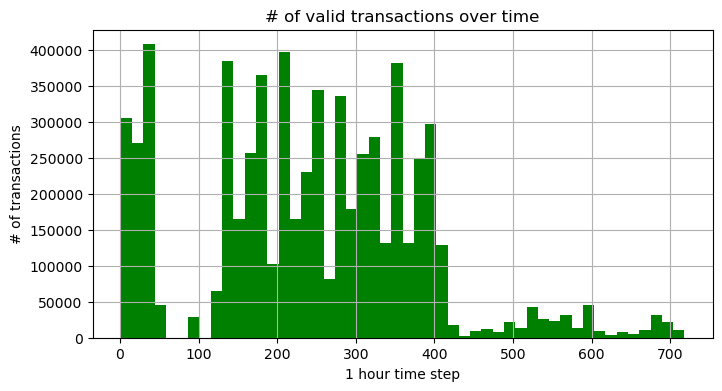

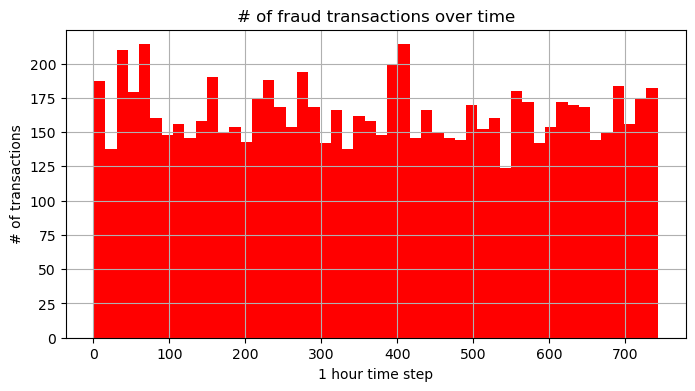

<Figure size 2000x1000 with 0 Axes>

In [18]:
bins = 50

df[(df['isFraud'] == 0)].hist(column="step",color="green",bins=bins)
plt.xlabel("1 hour time step")
plt.ylabel("# of transactions")
plt.title("# of valid transactions over time")

df[(df['isFraud'] == 1)].hist(column ="step",color="red",bins=bins)
plt.xlabel("1 hour time step")
plt.ylabel("# of transactions")
plt.title("# of fraud transactions over time")

plt.figure(figsize=(20,10))
plt.show()


Se puede observar que luego de las 400 horas las transacciones reales disminuyen considerablemente, mientras que las fraudulentas se mantienen constantes.

Esto nos indica que luego de las 400 horas de efectuada la transacción, si el ritmo no disminuye hay más posibilidad de que sean operaciones fraudulentas.

**MODELADO DE LOS DATOS**
--

Como podemos ver nuestro dataset cuenta con variables categóricas y numéricas. Lo que debemos hacer es primero eliminar las variables que no son relevantes y a las categóricas transformarlas en numéricas

In [19]:
# Transformamos las categorías de "type" en columnas con la función get_dummie
dataset = pd.concat([df.drop(columns=['isFraud','isFlaggedFraud']),pd.get_dummies(df.type)] ,axis=1)

# Eliminamos las columnas que no van a ser relevantes para este estudio
dataset = dataset.drop(['type', 'nameOrig', 'nameDest'],1)

# concatenamos df con dataset para finalizar
dataset = pd.concat([dataset,df.iloc[:,-2:]],axis=1)

dataset.head()

C:\Users\Francisco\AppData\Local\Temp\ipykernel_5724\678391866.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  dataset = dataset.drop(['type', 'nameOrig', 'nameDest'],1)


,step,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFraud,isFlaggedFraud
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0,0,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0,0,0
2,1,181.00,181.0,0.00,0.0,0.0,0,0,0,0,1,1,0
3,1,181.00,181.0,0.00,21182.0,0.0,0,1,0,0,0,1,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,1,0,0,0


**ANÁLISIS DE REDUNDANCIA**

En este paso se comprobará la redundancia de cada propiedad mediante la correlación de Pearson usando un mapa de calor con la libreria Seaborn.

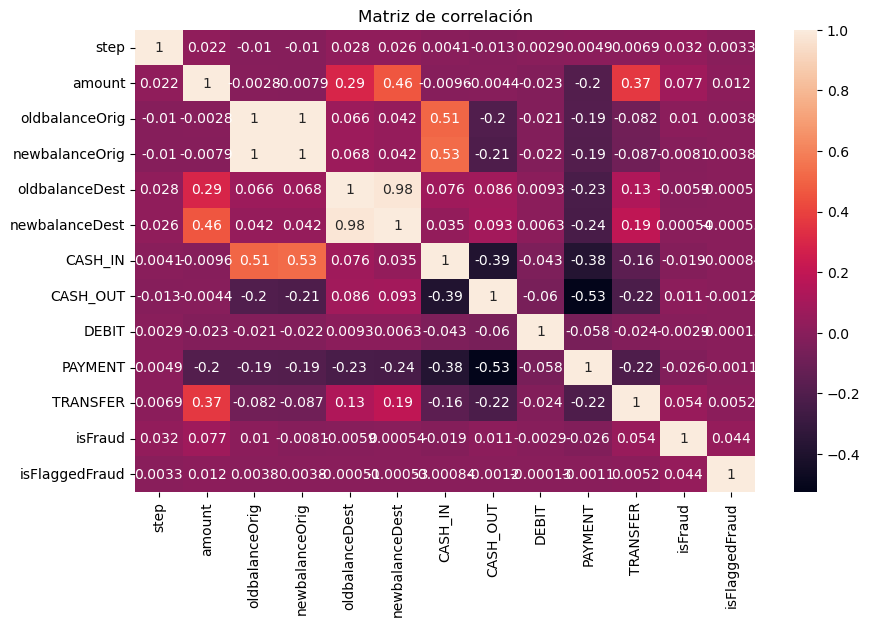

In [20]:
corrmat = dataset.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corrmat, annot=True)
plt.title("Matriz de correlación")
plt.show()

**Respuesta a la pregunta 3: ¿Cuáles son las propiedades que mayor correlatividad tienen con nuestra variable objetivo?**

Se puede observar una enorme correlacion enre las siguientes variables:

oldbalanceDest y newbalanceDest
oldbalanceOrg y newbalanceOrig
Esta correlación es debida a la clara influencia que existen entre las variables. Por ejemplo, cuando se envia dinero a un destinatario, ese alguien aumenta su capital, mientras que el origen disminuye.

**Duplicados**

Ahora comprobaremos que no existan registros duplicados mediante el método de python duplicated(), selecciona los registros coincidentes, excepto la primera ocurrencia de cada coincidencia, basandose en todas las columnas

In [21]:
df.duplicated().any()

False

**ENTRENAMIENTO DEL ALGORITMO**
--

Para este método de estudio aplicamos el algoritmo de Arbol de decisiones y la regresión logística que creo darían una respuesta bastante precisa

**Parte 1: Arbol de decisiones sin balanceo de clases**

In [22]:
# Separamos nuestro dataframe en una parte de entrenamiento y una de testeo
train_X, test_X, train_y, test_y = train_test_split( dataset.drop(columns=["isFraud"]), dataset['isFraud'], random_state=0)

# Se escoge el arbol de decisiones
DT = tree.DecisionTreeClassifier()

# se entrena el modelo con el dataset de entrenamiento
DT.fit(train_X, train_y)

# predice la clase de test
DTpredictions = DT.predict(test_X)

In [23]:
# Evaluamos nuestra predicción
print(DT.score(test_X, test_y))
print(confusion_matrix(test_y, DTpredictions))
print(classification_report(test_y, DTpredictions))

0.9997089249397261
[[1588409     219]
 [    244    1783]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588628
           1       0.89      0.88      0.89      2027

    accuracy                           1.00   1590655
   macro avg       0.95      0.94      0.94   1590655
weighted avg       1.00      1.00      1.00   1590655



**Resultado 1: Arbol de decisiones sin balanceo de clases**

Se observa un buen rendimiento pero se nota que detecta mejor una clase que otra

Podríamos probar balanceando las clases

**Parte 2: Regresión logística sin balanceo de clases**

In [24]:
# Se escoge la regresión logística
LR = LogisticRegression()

# se entrena el modelo con el dataset de entrenamiento
LR.fit(train_X, train_y)

# predice la clase de test
LRpredictions = LR.predict(test_X)

In [25]:
print(LR.score(test_X, test_y))
print(confusion_matrix(test_y, LRpredictions))
print(classification_report(test_y, LRpredictions))

0.9982874979175246
[[1587063    1565]
 [   1159     868]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588628
           1       0.36      0.43      0.39      2027

    accuracy                           1.00   1590655
   macro avg       0.68      0.71      0.69   1590655
weighted avg       1.00      1.00      1.00   1590655



Se aprecia que, aunque el accuracy del modelo es del 99.8%, este no es tan bueno como parece.

Si nos fijamos en la matriz de confusión, este modelo clasifica perfectamente las operaciones reales, pero las que son fraudulentas sólo es capaz de clasificarlas correctamente un 34% de las veces. Esto se debe a que al estar desbalanceadas las clases el modelo generaliza tendiendo a clasificar las operaciones como reales, ya que las reales representan la mayoria de los casos

**BALANCEO DE CLASES**

Al contar con esta ingente cantidad de observaciones, se aprecia un desbalenceo importante en las clases de la variable objetivo. El porcentaje de observaciones clasificadas como fraudes es de apenas un 0.13%

In [26]:
total = dataset['isFraud'].value_counts()[0] + df['isFraud'].value_counts()[1]
fraud = (df['isFraud'].value_counts()[1]/total) * 100
print(f'El porcentaje de operaciones fraudulentas es {fraud: .2f} %')

El porcentaje de operaciones fraudulentas es  0.13 %


Probaremos balancear las clases mediante los métodos oversampling, undersampling y smooten que combina ambos para ver cuál da mejores resultados

**Undersampling**

Consiste en eliminar muestras de la clase mayoritaria para poder nivelar ambas clases.

In [27]:
columns = dataset.columns

# Creamos las variables independientes, y la dependiente que sería isFraud = 1
X = dataset.drop('isFraud',1)
y = dataset.isFraud

# Balanceamos la cantidad de muestras para que se equiparen con las de menor cantidad
undersample = RandomUnderSampler(random_state=0)
X_under, y_under = undersample.fit_resample(X, y)

print(pd.Series(y_under).value_counts())

C:\Users\Francisco\AppData\Local\Temp\ipykernel_5724\1315434665.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = dataset.drop('isFraud',1)


0    8213
1    8213
Name: isFraud, dtype: int64


In [28]:
columns_X = np.delete(columns, 11)
columns_y = columns[-2]

In [29]:
X_df = pd.DataFrame(X_under, columns=columns_X)
y_df = pd.DataFrame(y_under, columns=[columns_y])

under_df = pd.concat([X_df, y_df], axis=1)
under_df.head()

,step,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFlaggedFraud,isFraud
0,139,265803.35,0.00,0.00,751669.39,1017472.74,0,1,0,0,0,0,0
1,589,11278.28,0.00,0.00,220970.84,232249.12,0,1,0,0,0,0,0
2,284,16363.06,35966.16,19603.10,0.00,0.00,0,0,0,1,0,0,0
3,37,107223.31,20752629.71,20859853.02,804594.62,571711.22,1,0,0,0,0,0,0
4,287,3678.25,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0


In [30]:
# Separamos nuestro dataframe en una parte de entrenamiento y una de testeo
train_X, test_X, train_y, test_y = train_test_split( under_df.drop(columns=["isFraud"]), under_df['isFraud'], random_state=0)

**Parte 3: Arbol de decisión con undersampling**

In [31]:
# Se escoge el arbol de decisiones
DT = tree.DecisionTreeClassifier()

# se entrena el modelo con el dataset de entrenamiento
DT.fit(train_X, train_y)

# predecimos la clase con los datos de prueba
DTpredictions_under = DT.predict(test_X)

In [32]:
# Evaluamos la predicción
print(DT.score(test_X, test_y))
print(confusion_matrix(test_y, DTpredictions_under))
print(classification_report(test_y, DTpredictions_under))

0.990990990990991
[[2016   19]
 [  18 2054]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2035
           1       0.99      0.99      0.99      2072

    accuracy                           0.99      4107
   macro avg       0.99      0.99      0.99      4107
weighted avg       0.99      0.99      0.99      4107



**Respuesta 3: Arbol de deciciones con undersampling**

Ha mejorado la predicciónes acertadas de las observaciones que son fraude, y disminuido apenas las que no lo son. En general, ahora es un mejor modelo que sin balanceo

**Parte 4: Regresión loística con undersampling**

In [33]:
# Se escoge la regresión logística
RL = LogisticRegression()

# se entrena el modelo con el dataset de entrenamiento
RL.fit(train_X, train_y)

# predecimos la clase con los datos de prueba
RLpredictions_under = RL.predict(test_X)

In [34]:
# Evaluamos la predicción
print(RL.score(test_X, test_y))
print(confusion_matrix(test_y, RLpredictions_under))
print(classification_report(test_y, RLpredictions_under))

0.911127343559776
[[1866  169]
 [ 196 1876]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2035
           1       0.92      0.91      0.91      2072

    accuracy                           0.91      4107
   macro avg       0.91      0.91      0.91      4107
weighted avg       0.91      0.91      0.91      4107



**Respuesta 4: Regresión Logistica con undersampling**

Se aprecia una importante mejora en la precisión de las predicciones, debido al balanceado de las clases

**Oversampling**

Es un método para balancear las clases, consiste en agregar datos en la clase con menos cantidad de muestras. Para ello nos valemos del algoritmo de K-vecino, método por el cual se sintetizan datos analizando los patrones de los datos reales y sintetizando nuevas muestras en base a esa relación

In [35]:
columns = dataset.columns

# Creamos las variables independientes, y la dependiente que sería isFraud = 1
X = dataset.drop('isFraud',1)
y = dataset.isFraud

# Balanceamos la cantidad de muestras para que se equiparen con las de menor cantidad
oversample = RandomOverSampler(random_state=0)
X_over, y_over = oversample.fit_resample(X, y)

print(pd.Series(y_over).value_counts())

C:\Users\Francisco\AppData\Local\Temp\ipykernel_5724\3853254621.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = dataset.drop('isFraud',1)


0    6354407
1    6354407
Name: isFraud, dtype: int64


In [36]:
columns_X = np.delete(columns, 11)
columns_y = columns[-2]

In [37]:
X_df = pd.DataFrame(X_over, columns=columns_X)
y_df = pd.DataFrame(y_over, columns=[columns_y])

over_df = pd.concat([X_df, y_df], axis=1)
over_df.head()

,step,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFlaggedFraud,isFraud
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0,0,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0,0,0
2,1,181.00,181.0,0.00,0.0,0.0,0,0,0,0,1,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,0,1,0,0,0,0,1
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,1,0,0,0


In [38]:
# Separamos nuestro dataframe en una parte de entrenamiento y una de testeo
train_X, test_X, train_y, test_y = train_test_split( over_df.drop(columns=["isFraud"]), over_df['isFraud'], random_state=0)

**Parte 5: Arbol de decisiones con oversampling**

In [39]:
# Se escoge el arbol de decisiones
DT = tree.DecisionTreeClassifier()

# se entrena el modelo con el dataset de entrenamiento
DT.fit(train_X, train_y)

# predecimos la clase con los datos de prueba
DTpredictions_over = DT.predict(test_X)

In [40]:
# Evaluamos la predicción
print(DT.score(test_X, test_y))
print(confusion_matrix(test_y, DTpredictions_over))
print(classification_report(test_y, DTpredictions_over))

0.9999128164260148
[[1587641     277]
 [      0 1589286]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1587918
           1       1.00      1.00      1.00   1589286

    accuracy                           1.00   3177204
   macro avg       1.00      1.00      1.00   3177204
weighted avg       1.00      1.00      1.00   3177204



**Resultado 5: Arbol de decisiones con oversampling**

Como podemos ver obtuvimos un accuracy, un recall y un f1-score de prácticamente el 100% y solo falló en 277 casos que representan el 0.008% de los casos totales.

**Parte 6: Regresión logistica con oversampling**

In [41]:
# Se escoge la regresión logística
RL = LogisticRegression()

# se entrena el modelo con el dataset de entrenamiento
RL.fit(train_X, train_y)

# predecimos la clase con los datos de prueba
RLpredictions_over = RL.predict(test_X)

In [42]:
# Evaluamos la predicción
print(RL.score(test_X, test_y))
print(confusion_matrix(test_y, RLpredictions_over))
print(classification_report(test_y, RLpredictions_over))

0.9039932594822366
[[1446883  141035]
 [ 163998 1425288]]
              precision    recall  f1-score   support

           0       0.90      0.91      0.90   1587918
           1       0.91      0.90      0.90   1589286

    accuracy                           0.90   3177204
   macro avg       0.90      0.90      0.90   3177204
weighted avg       0.90      0.90      0.90   3177204



**Resultado 6: Regresión logistica con oversampling**

Vemos que los resultados de las predicciones con oversampling son mejores que con los datos sin balancear, pero sorprendentemente son menores al modelo con undersampling. 

**Validación Cruzada**
--

Para constatar la efectividad real de la performance de nuestro algoritmo aplicaremos validación cruzada, es decir, dividiremos nuestro dataset en secciones para poder generar iteraciones donde los datos se representan en distinto orden y comprobamos si la performance en cada caso es la misma. En este caso dividiremos nuestros datos en 5 pliegues para poder realizar 5 mediciones y cruzarlas.

In [43]:
# Segmentamos los datos para poder realizar la validación cruzada
score = crossval(DT, test_X, test_y, cv=10)
print(score)
print(f'El promedio de nuestro accuracy es de {score.mean():.6f} % y la desviación estandar es de {score.std():.6f} %')

[0.99980801 0.99980801 0.99982689 0.99982689 0.99984892 0.99979856
 0.99983319 0.99981745 0.99980171 0.99978912]
El promedio de nuestro accuracy es de 0.999816 % y la desviación estandar es de 0.000017 %


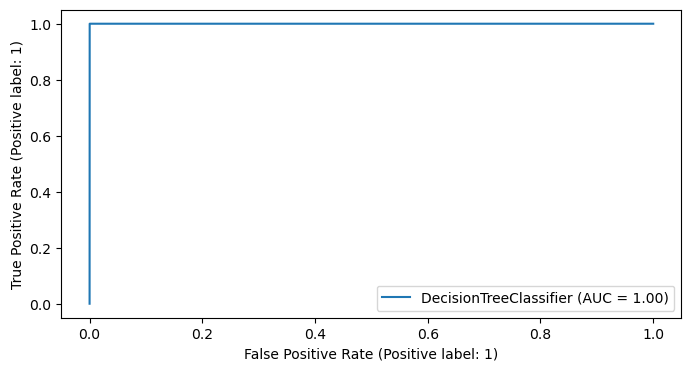

In [44]:
RocCurveDisplay.from_estimator(DT, test_X, test_y)
plt.show()

Devido a la alta precisión de nuestro algoritmo optimizado por balanceo podríamos decir que el mismo se adapta muy bien a los datos sintetizados. Si esto pasara con datos reales, sería de suma utilidad incluir el algoritmo en un sistema de deteccion de fraude en tiempo real para poder bloquear transacciones e informar a los usuarios de las cuentas bancarias de origen.

Pero para fines didácticos avanzaremos un paso mas e incluiremos un proceso de optimización de hiperparámetros mediante el método Grid Search

In [45]:
# Definimos los parámetros que queremos ajustar
parameters = {'max_leaf_nodes': [1, 2, 3],
              'min_samples_split': [1, 3, 4],
              'random_state': [0, 2, 5]
             }

GS = GridSearchCV(estimator = DT,
                  param_grid = parameters,
                  scoring = 'r2',
                  refit = 'r2',
                  cv = 5,
                  verbose = 4
                 )

GS.fit(train_X, train_y)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END max_leaf_nodes=1, min_samples_split=1, random_state=0;, score=nan total time=  26.2s
[CV 2/5] END max_leaf_nodes=1, min_samples_split=1, random_state=0;, score=nan total time=   1.1s
[CV 3/5] END max_leaf_nodes=1, min_samples_split=1, random_state=0;, score=nan total time=   1.0s
[CV 4/5] END max_leaf_nodes=1, min_samples_split=1, random_state=0;, score=nan total time=   1.2s
[CV 5/5] END max_leaf_nodes=1, min_samples_split=1, random_state=0;, score=nan total time=   1.0s
[CV 1/5] END max_leaf_nodes=1, min_samples_split=1, random_state=2;, score=nan total time=   0.9s
[CV 2/5] END max_leaf_nodes=1, min_samples_split=1, random_state=2;, score=nan total time=   0.7s
[CV 3/5] END max_leaf_nodes=1, min_samples_split=1, random_state=2;, score=nan total time=   0.7s
[CV 4/5] END max_leaf_nodes=1, min_samples_split=1, random_state=2;, score=nan total time=   0.8s
[CV 5/5] END max_leaf_nodes=1, min_samples_split=1, rand

C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\tree\_classes.py", line 177, in fit
    self._

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_leaf_nodes': [1, 2, 3],
                         'min_samples_split': [1, 3, 4],
                         'random_state': [0, 2, 5]},
             refit='r2', scoring='r2', verbose=4)

**Resumen**
--

En resumen podemos determinar que con los datos balanceados se obtienen modelos mas precisos. El que mejor resultado dio fue el modelo de arbol de decisiones con oversampling, el cual dio un accuracy de, prácticamente, el 100%. Resultado mas que suficiente para este modelo usado solamente de forma didáctica. 

Se intentó realizar una optimización de hiperparámetros pero no dio mejores resultados que el ya obtenido.

En un caso real se podría probar aplicar otros métodos de balanceo como Smooth y otros modelos de ML, como Random Forest, para tratar de mejorar la precisión y evitar esos 277 falsos positivos. Con este tipo de precisión ya es suficiente para poder aplicarlo en un sistema real, el algoritmo podría aplicarse a un sistema que prevenga fraudes en tiempo real y de aviso a los clientes y administradores de cuentas.